In [1]:
# !pip install matplotlib
# !pip install forallpeople

In [2]:
import csv
from dataclasses import dataclass, field, asdict, astuple
from typing import List
from collections import namedtuple
from functools import reduce
from functools import partial
import forallpeople as si ## 단위 변환 관련 패키지(아직 미사용)
import math
import matplotlib.pyplot as plt

In [3]:
#################################Module For Functional Programing#############################################
curry = lambda f: lambda a,*args: f(a, *args) if (len(args)) else lambda *args: f(a, *args)

add = curry(lambda a,b: a + b)

filter = curry(filter)
map = curry(map)

def _take(length, iter):
    res = []
    for a in iter:
        res.append(a)
        if len(res) == length:
            return res
        
take = curry(_take)
reduce = curry(reduce)

go = lambda *args: reduce(lambda a,f: f(a), args) ## 함수도 축약 가능 ##
##############################################################################################################

In [4]:
## 함수형 프로그래밍 코드 사용 예제
example = lambda _list: go\
(
    _list,
    filter(lambda a: not a % 2),
    filter(lambda a: not a % 4),
    map(lambda a: a * a + 5),
    reduce(add)
)

In [5]:
example([1,2,3,4,5,6])

21

# Library Module Code Part

In [6]:
## 사용 예시

####### 사용자 입력부 #######
input_path = 'Section Profile.csv'

input_dsgnMode = "LRFD"

input_fy = 344.738 ## 50
input_E = 199900 ## 29000

input_DL = 6.567
input_LL = 10.945
input_length = 10670

input_cb_mode = "Cb고려"
input_table_mode = "continuous"
input_brace_idx = 2

#############################

<br>

## 0. 단면 정보 import (선언부)

In [7]:
def importCSV(_path):
    with open(_path,'r') as f:
        reader  = csv.reader(f) # csv의 행별로 읽어옴

        res = [x for x in reader]
    return res

In [8]:
def exportCSV(_filename, _datas):
    f = open(_filename, 'w', newline='') # 자동줄바꿈 방지 header 이후 첫행 빈행 생성 방지
    csv_writer = csv.writer(f)
    
    for x in _datas:
        csv_writer.writerow(x)
    f.close()

In [9]:
dfSectionProfile = importCSV(input_path)
dfHeader = dfSectionProfile.pop(0) #pop(0)의 의미 첫행을 값을 반환하고 나머지 리스트는 저장

## 1. 단면 자료형 Setter (선언부)

In [10]:
def makeSectionForm(args):
    
    Form = namedtuple('SectionForm', ['ID','shape','h','bf','tw','tf','k'])
    form = \
        Form(ID=args[0], shape=args[1], 
            h=float(args[2]), bf=float(args[3]), 
            tw=float(args[4]), tf=float(args[5]), k=float(args[6]))        
    
    return form


### 예시 ###
sForm = makeSectionForm(dfSectionProfile[294])

<br><br><br>
## 2. 단면 속성 Setter (선언부)

In [11]:
def setSectionProp(sForm):
    def defineC():
        if _shape == "W" or _shape == "H": return 1
        elif _shape == "C": return (_h0/2) * (_Iy/_Cw)**0.5
        else: return 1 ## 임시 대처
        
    Prop = namedtuple(
        'SectionProperty', 
        ['ID', 'h', 'bf', 'tw', 'tf', 'k', 'shape', 'Area', 'Weight', 
         'Ix', 'Sx', 'Zx', 'rx', 'Iy', 'Sy', 'Zy', 'ry', 
         'Cw', 'J', 'rts', 'h0', 'C'])
    
    (_ID,_h,_bf,_tw,_tf,_k,_shape) = (sForm.ID,sForm.h,sForm.bf,sForm.tw,sForm.tf,sForm.k,sForm.shape)
    _Area = 2*_tf*_bf+(_h-2*_tf)*_tw
    _Weight = _Area*77.22/10**6
    _Ix = (2*(_bf*_tf**3/12+_bf*_tf*((_h-2*_tf)/2+_tf/2)**2)+_tw*(_h-2*_tf)**3/12) 
    _Sx = _Ix/(_h/2)
    _Zx = _bf*_tf*(_h-_tf)+0.25*(_h-2*_tf)**2*_tw
    _rx = (_Ix/_Area)**0.5
    _Iy = 2*(_tf*(_bf)**3/12)+(_h-2*_tf)*(_tw)**3/12
    _Sy = _Iy/(_bf/2)
    _Zy = 0.5*(_bf)**2*_tf+0.25*(_h-2*_tf)*(_tw)**2
    _ry = (_Iy/_Area)**0.5
    _Cw = (_h-_tf)**2*_bf**3*_tf/24
    (_J,_rts,_h0,_C) = ((2*_bf*_tf**3+(_h-_tf)*_tw**3)/3, ((_Iy*_Cw)**0.5/_Sx)**0.5, _h-_tf, defineC())
    
    prop = Prop(
        ID= _ID, h= _h, bf= _bf, tw= _tw, tf= _tf, k= _k, shape= _shape, Area= _Area, Weight= _Weight,
        Ix= _Ix, Sx= _Sx, Zx= _Zx, rx= _rx, Iy= _Iy, Sy= _Sy, Zy= _Zy, ry= _ry,
        Cw= _Cw, J= _J, rts= _rts, h0= _h0, C= _C)
    
    return prop

### 예시 ###
aa = setSectionProp(sForm)
aa

SectionProperty(ID='H-248×124x5x8', h=248.0, bf=124.0, tw=5.0, tf=8.0, k=12.0, shape='H', Area=3144.0, Weight=0.24277968, Ix=33783168.0, Sx=272444.9032258064, Zx=305360.0, rx=103.65945418893585, Iy=2544582.0, Sy=41041.645161290326, Zy=62954.0, ry=28.44899681618542, Cw=36607180800.0, J=52325.333333333336, rts=33.470048360084256, h0=240.0, C=1)

<br><br><br>
## 3. 재료 속성 Setter (선언부)

In [12]:
def setMaterialProp(_fy, _E):
    Prop = namedtuple('MaterialProperty', ['fy', 'E'])
    prop = Prop(fy=_fy, E=_E)
    
    return prop

### 예시 ###
mProp = setMaterialProp(344.738, 199900)

## 4. 디자인 베이스 Setter (선언부)

In [13]:
def setDesignBase(_DL, _LL, _length):
    Base = namedtuple('DesignBase', ['DL', 'LL', 'length'])
    base = Base(DL=_DL, LL=_LL, length=_length)
    
    return base

### 예시 ###
dBase = setDesignBase(input_DL, input_LL, input_length)
dBase

DesignBase(DL=6.567, LL=10.945, length=10670)

## 5. 서브 디자인 베이스 Setter (선언부)

In [45]:
def setFlexureBase(cb_mode, table_mode, _brace_idx):
    Base = namedtuple('SubBase_flx', ['brace_idx', 'Cb'])

    def findCb():
        _none = {
            "1p": [[1.32]],
            "2p": [[1.14]],
            "3p": [[1.14]],
            "continuous": [[1.14]] }

        _atLoad = {
            "1p": [1.67, 1.67],
            "2p": [1.67, 1.00, 1.67],
            "3p": [1.67, 1.11, 1.11, 1.67],
            "continuous": 
                [[1.30, 1.30], 
                [1.45, 1.01, 1.45], 
                [1.52, 1.06, 1.06, 1.52], 
                [1.56, 1.12, 1.00, 1.12, 1.56]] }
        if cb_mode == "Cb고려":
            if _brace_idx == 0:
                result = _none[table_mode][_brace_idx]
            else:
                result = _atLoad[table_mode][_brace_idx-1]
        elif cb_mode == "Cb미고려":
            result = [ 1.00 ]

        return result
    
    base = Base(brace_idx= _brace_idx, Cb=findCb())    
    return base

### 예시 ###
fBase = setFlexureBase("Cb고려", "3p", 3)
fBase

SubBase_flx(brace_idx=3, Cb=1.11)

## 6. 디자인 결과 Checker (선언부)

In [15]:
def checkDesignResult(_dsgnMode, _sProp, _mProp, _dBase, _subBaseColl, _subCheckColl):
    
    def calcRequired(_dsgnMode):
        def _calcStr():
            if _dsgnMode == "LRFD":
                result = 1.2*_dBase.DL + 1.6*_dBase.LL
            elif _dsgnMode == "ASD":
                result = _dBase.DL + _dBase.LL
            else:
                result = "check the DesignMode"
            return result
        
        def _calcMoment():
            result = ((_calcStr() * _dBase.length**2) / 8) / 1000**2
            return result

        return (_calcStr(), _calcMoment())
    
    fCheck = _subCheckColl.fCheck
    fBase = _subBaseColl.fBase
    
    def chkDesignResult(_dsgnMode, _sProp, _mProp, _dBase, _subBase, _subCheck):
        NomStr = _subCheck(_dsgnMode,_sProp, _mProp, _dBase, _subBase)
        
        if NomStr > calcRequired(_dsgnMode)[1]:
            return f"nominal: {NomStr:.2f} kN·m > required: {calcRequired(_dsgnMode)[1]:.2f} kN·m.  So, It's O.K."
        else:
            return f"nominal: {NomStr:.2f} kN·m < required: {calcRequired(_dsgnMode)[1]:.2f} kN·m. So, It's N.G."
    
    result_flx = chkDesignResult(_dsgnMode, _sProp, _mProp, _dBase, fBase,fCheck)
    
    return result_flx

## 6.a 서브 디자인 결과 Checker_휨 (선언부)

In [16]:
def checkFlexure(_dsgnMode,_sProp, _mProp, _dBase, _subBase):
    
    def findLp():
        return 1.76 * _sProp.ry * (_mProp.E/_mProp.fy)**0.5
    
    def findLr():
        return 1.95*_sProp.rts*_mProp.E/(0.7*_mProp.fy)*(_sProp.J/(_sProp.Sx*(_sProp.h0))+((_sProp.J/(_sProp.Sx*(_sProp.h0)))**2+6.76*(0.7*_mProp.fy/_mProp.E)**2)**0.5)**0.5
    
    def findMp():
        ### for Strong Axis ###
        Mp_x = _mProp.fy * _sProp.Zx
        ### for Weak Axis ###
        Mp_y = min([(_mProp.fy * _sProp.Zy), (1.6*_mProp.fy*_sProp.Sy)])
        
        return {"Mp_x": Mp_x, "Mp_y": Mp_y}
    
    def findMn(): ### for Strong Axis ###
        (Mp,Lp,Lr,Lb) = (findMp()["Mp_x"], findLp(), findLr(), _dBase.length/(_subBase.brace_idx+1))
        
        if Lb <= Lp:
            Mn = Mp
        elif Lp < Lb <= Lr:
            Mn = min(map(lambda x: x * (Mp-(Mp-0.7*_mProp.fy*_sProp.Sx)*((Lb-Lp) / (Lr-Lp))), _subBase.Cb))
        elif Lb > Lr:
            Fcr = min(map(lambda x: (x * (math.pi**2 * _mProp.E)/((Lb/_sProp.rts)**2)) * (1 + 0.078*(((_sProp.J*_sProp.C)/(_sProp.Sx*_sProp.h0))*(Lb/_sProp.rts)**2))**0.5 ,_subBase.Cb))
            Mn = min((Fcr)*_sProp.Sx, Mp)
        
        return Mn / 1000**2
    
    
    def calcNominal():
        if _dsgnMode == "LRFD":
            result = 0.90 * findMn()
        elif _dsgnMode == "ASD":
            result = findMn() / 1.67
        else:
            result = "check the DesignMode"
        return result
    
    def chkDesignResult():
        if self.calcNominal() > self.calcRequired()[1]:
            return f"nominal: {self.nominal:.2f} kN·m > required: {self.required[1]:.2f} kN·m.  So, It's O.K."
        else:
            return f"nominal: {self.nominal:.2f} kN·m < required: {self.required[1]:.2f} kN·m. So, It's N.G."
        
    return calcNominal()

## 6.b 서브 디자인 결과 Checker_압축 (선언부)

In [17]:
def checkCompression(_dsgnMode,_sProp, _mProp, _dBase, _subBase):
    pass

## 6.c 서브 디자인 결과 Checker_인장 (선언부)

In [18]:
def checkTension(_dsgnMode,_sProp, _mProp, _dBase, _subBase):
    pass

## 6.d 서브 디자인 결과 Checker_복합력 (선언부)

In [19]:
def checkCombined(_dsgnMode,_sProp, _mProp, _dBase, _subBase):
    pass

# Client Code Part

## << 단일 부재 검토 Mode >>

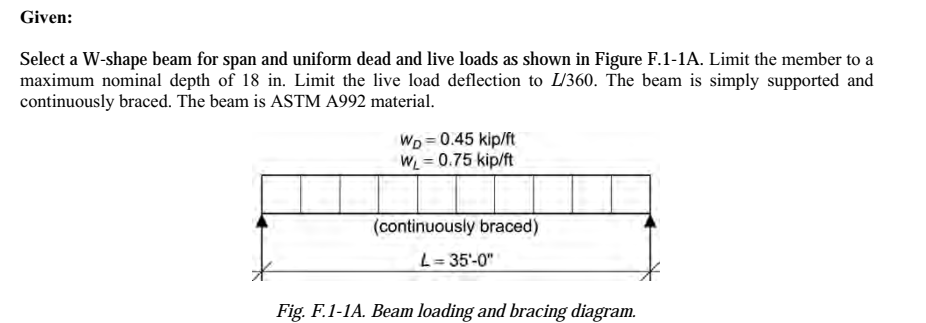

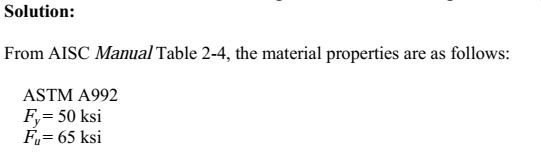

### ------- 사용자 입력부 -------

In [20]:
## 사용 예시

####### 사용자 입력부 #######
input_path = 'Section Profile.csv'

input_dsgnMode = "LRFD"

input_fy = 344.738 ## 50
input_E = 199900 ## 29000

input_DL = 6.567
input_LL = 10.945
input_length = 10670

input_cb_mode = "Cb고려"
input_table_mode = "continuous"
input_brace_idx = 2

#############################

### -----------------------------------

### 0. 단면 정보 import (사용부)

In [21]:
dfSectionProfile = importCSV(input_path)
dfSectionProfile.remove(dfSectionProfile[0])
# dfSectionProfile

### 1. 단면 자료형 Setter (사용부)

In [22]:
targetSection = makeSectionForm(dfSectionProfile[160])

### 2. 단면 속성 Setter (사용부)

In [23]:
sProp = setSectionProp(targetSection)

### 3. 재료 속성 Setter (사용부)

In [24]:
mProp = setMaterialProp(input_fy, input_E)

### 4.디자인 베이스 Setter (사용부)

In [25]:
dBase = setDesignBase(input_DL, input_LL, input_length)

### 5. 서브 디자인 베이스 Setter (사용부)

In [26]:
mkSubBaseColl = namedtuple('subBaseColl', 'fBase, cBase, tBase')
subBase_flx = setFlexureBase(input_cb_mode, input_table_mode, input_brace_idx)
subBaseColl = mkSubBaseColl(fBase=subBase_flx, cBase=0, tBase=0)

### 6.a, b, c. 서브 디자인 결과 Checker (사용부)

In [27]:
mkSubCheckColl = namedtuple('subCheckColl', 'fCheck, cCheck, tCheck')
subCheck_flx = checkFlexure
subCheckColl = mkSubCheckColl(fCheck=subCheck_flx, cCheck=0, tCheck=0)

### 6. 디자인 결과 Checker (사용부)

In [28]:
checkDesignResult(input_dsgnMode, sProp, mProp, dBase, subBaseColl, subCheckColl)

"nominal: 411.69 kN·m > required: 361.36 kN·m.  So, It's O.K."

## << 다중 부재 검토 Mode >>

### ------- 사용자 입력부 -------

In [29]:
## 사용 예시

####### 사용자 입력부 #######
input_path = 'Section Profile.csv'


input_dsgnMode = "LRFD"

input_fy = 344.738 ## 50
input_E = 199900 ## 29000

input_DL = 6.567
input_LL = 10.945
input_length = 10670

input_cb_mode = "Cb고려"
input_table_mode = "continuous"
input_brace_idx = 2

#############################

### -----------------------------------

### 0 ~ 1. 다중 단면 자료형 세팅

In [30]:
## 여기서 makeSectionForms는 데이터를 저장하지 않고 함수 객체를 저장한다. C#, JAVA에서의 Delegate와 동일
makeSectionForms = \
lambda _list: go(
    _list,
    map(lambda x: makeSectionForm(x)),
    list
    )

In [31]:
#### 0. 단면 정보 import
dfSectionProfile = importCSV(input_path)
dfSectionProfile.remove(dfSectionProfile[0])

#### 1. 단면 자료형 setter
targetSections = makeSectionForms(dfSectionProfile)

### 2 ~ 6. 각종 Setter들 및 Checker들 고정 조건 세팅

In [32]:
### 고정 조건 세팅

#### 3. 재료속성
mProp = setMaterialProp(input_fy, input_E)

#### 4. 디자인 베이스 setter
dBase = setDesignBase(input_DL, input_LL, input_length)

#### 5. 서브 디자인 베이스 setter
mkSubBaseColl = namedtuple('subBaseColl', 'fBase, cBase, tBase')
subBase_flx = setFlexureBase(input_cb_mode, input_table_mode, input_brace_idx)
subBaseColl = mkSubBaseColl(fBase=subBase_flx, cBase=0, tBase=0)

#### 6.a~d 서브디자인 checker
mkSubCheckColl = namedtuple('subCheckColl', 'fCheck, cCheck, tCheck')
subCheck_flx = checkFlexure
subCheckColl = mkSubCheckColl(fCheck=subCheck_flx, cCheck=0, tCheck=0)

In [33]:
### 가변 조건 검토를 위한 함수 합성

multiChecker = lambda _list: go\
(
    _list,
    map(lambda x: makeSectionForm(x)),
    map(lambda x: setSectionProp(x)),
    map(lambda x: checkDesignResult(input_dsgnMode, x, mProp, dBase, subBaseColl, subCheckColl)),
    list
)

In [34]:
multiChecker(targetSections)

["nominal: 8219.64 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 7147.49 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 6409.00 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 5559.92 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 15562.29 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 13899.82 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 11690.61 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 9844.68 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 9052.46 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 8426.50 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 8197.37 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 7312.72 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 6617.07 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 6253.83 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nominal: 5604.58 kN·m > required: 361.36 kN·m.  So, It's O.K.",
 "nomin

## Class Structure Diagram

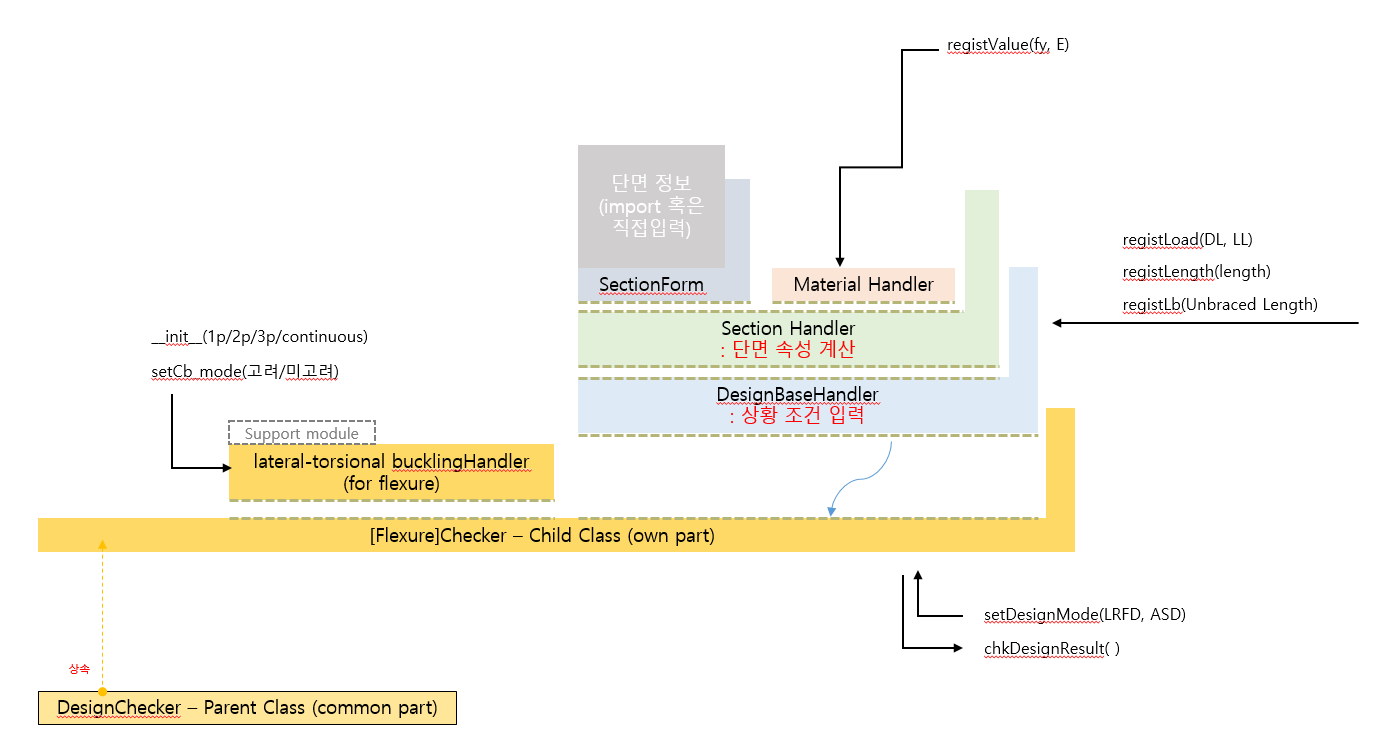

---
---

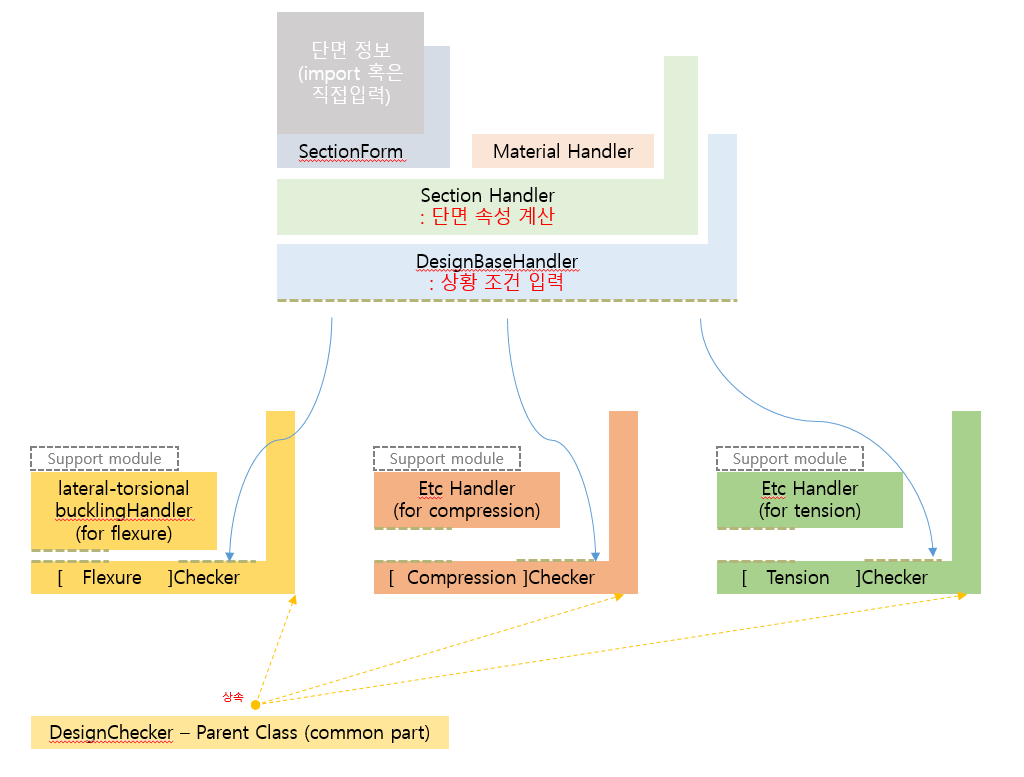